<a href="https://colab.research.google.com/github/rpradata-ud/DSPS_RPradata/blob/main/labs/Copy_of_RPradata_class_20_23_Gaussian_Process_Regression_WFF_23Oct2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1415)

first step generate synthetic dataset

# Generate Synthetic Dataset

In [ ]:
def gen_synthetic_data(nSynth, theta): #number of synth datapoints, and the parameter for our model

    # Generate synthetic sample points between -1 and 1.
   # X  = rng.uniform(low=-1, high=1, size=nSynth) #using the defined rng randomseed above. useful skill to use.
    X = np.linspace(-1, 1, num=nSynth)

    # Generate stochastic Gaussian noise for each sample.
    E = np.abs(rng.normal(loc=0, scale=0.25, size=nSynth))
    # E *= 0.00001

    # Use Kernel function to make covariance matrix.
    K = rbf_kernel(X, X, theta)

    # A diagnoal matrix containing the stochastic Gaussian noise.
    W = white_noise_kernel(E)

    # C + W is the covariance matrix of the posterior distribution. Sample from it at mean 0.
    Y = rng.multivariate_normal(np.zeros(nSynth), K + W)

    return X, Y, E, K, W


def rbf_kernel(X1, X2, theta):
    uu, vv = np.meshgrid(X1, X2) #what is this?
    return np.exp(-(vv - uu)**2 / (2 * theta**2))


def white_noise_kernel(E):
    return np.diag(E**2)

see for covariance function: eqn. 4.9 in MIT textbook. kernel.
seeing for K, using kernel function to make covariance matrix.

etc ...

------------------------

In [ ]:
a = [1, 2, 3]
b = [-1, -2, -3]
aa, bb = np.meshgrid(a, b)

In [ ]:
aa

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [ ]:
bb

array([[-1, -1, -1],
       [-2, -2, -2],
       [-3, -3, -3]])

In [ ]:
aa * bb, aa+bb, np.sin(aa)

(array([[-1, -2, -3],
        [-2, -4, -6],
        [-3, -6, -9]]),
 array([[ 0,  1,  2],
        [-1,  0,  1],
        [-2, -1,  0]]),
 array([[0.84147098, 0.90929743, 0.14112001],
        [0.84147098, 0.90929743, 0.14112001],
        [0.84147098, 0.90929743, 0.14112001]]))

In [ ]:
a = np.linspace(0,10*np.pi, 100)

#visualizing with imshow

np.meshgrid. useful grid of 2 input array. by indexing result of meshgrip, you can index thru every single combination

----------


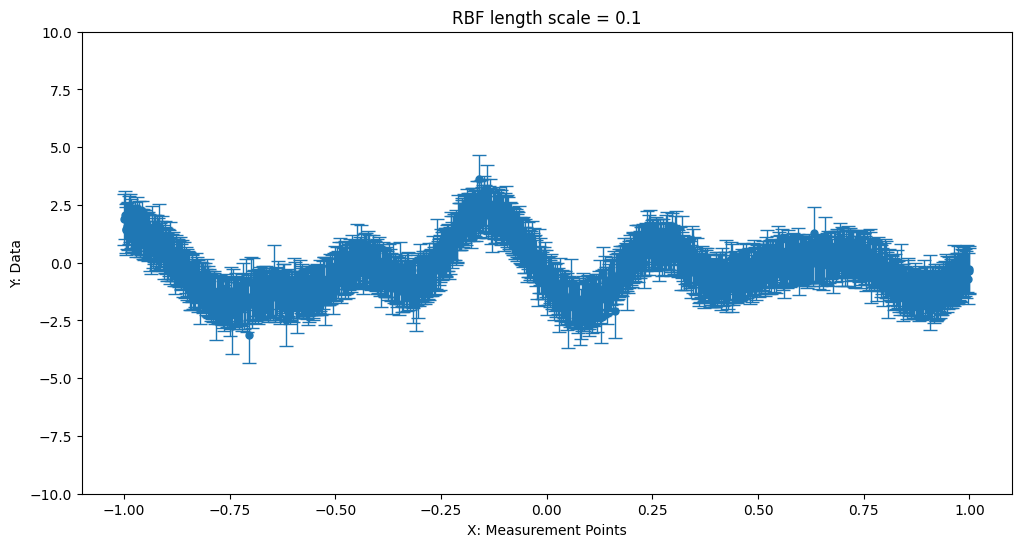

In [ ]:
theta = 0.1
nSynth = 1000
X, Y, E, K_true, W = gen_synthetic_data(nSynth, theta)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"RBF length scale = {theta}")

ax.errorbar(
    X, Y,
    yerr=np.sqrt(np.diag(K_true+W)),
    ls="", marker="o", ms=5,
    elinewidth=1, capsize=5,
    )

ax.set_ylim(-10, 10)
ax.set_xlabel("X: Measurement Points")
ax.set_ylabel("Y: Data")
fig.show()

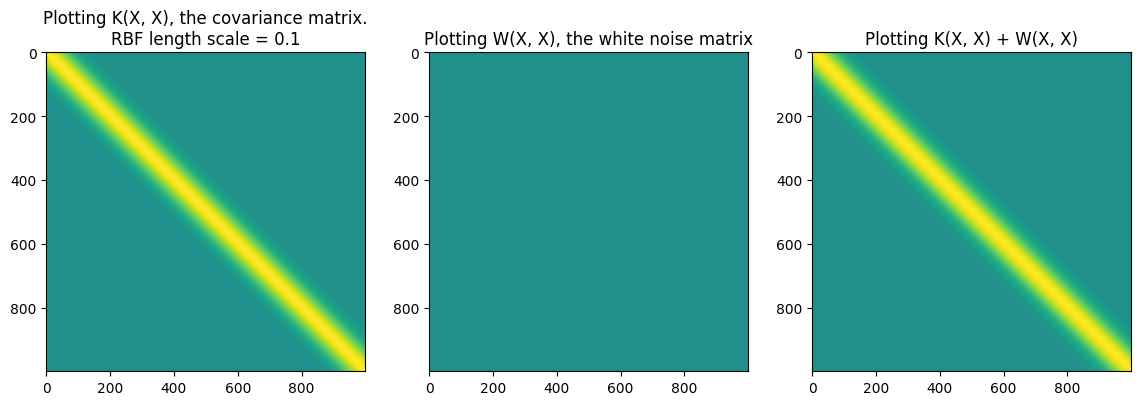

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

ax[0].set_title(f"Plotting K(X, X), the covariance matrix.\nRBF length scale = {theta}")
ax[0].imshow(K_true, vmin=-1, vmax=1)

ax[1].set_title("Plotting W(X, X), the white noise matrix")
ax[1].imshow(W, vmin=-1, vmax=1)

ax[2].set_title("Plotting K(X, X) + W(X, X)")
ax[2].imshow(K_true + W, vmin=-1, vmax=1)

fig.show()

^visualizing covariance matrix. what do you see?

- symmetric
- white noise smaller compared to k
- random relationship; random

every yellow point indicate strong covariance btwn two datapoints
##
^so we could order our data instead now. instead of ung.uniform, using np.linspace.

with np.linspace in the gen_synthetic_data function:

if we take point along diagonal, variance. but one diagonal off the main diagonal, that's one point covariance with its neighboors. until you get far away enough you don't see any covariance anymore.

so, farther away from each other, the points are less correlated.

we can also set theta! it changes the RBF shape, hence the colorbar too. See on own.

##
why does order of data generated matters

# Learn about Gaussian process fitting

In [ ]:
Xtrn, Xtst, Ytrn, Ytst, Etrn, Etst = train_test_split(X, Y, E, train_size=0.05, random_state=rng, shuffle=True)

#later on the 95% split


print(Xtrn.shape, Ytrn.shape, Etrn.shape)
print(Xtst.shape, Ytst.shape, Etst.shape) #it's important to always PRINT the resulting split sets!

num_trn = Xtrn.shape[0]
num_tst = Xtst.shape[0]

(50,) (50,) (50,)
(950,) (950,) (950,)


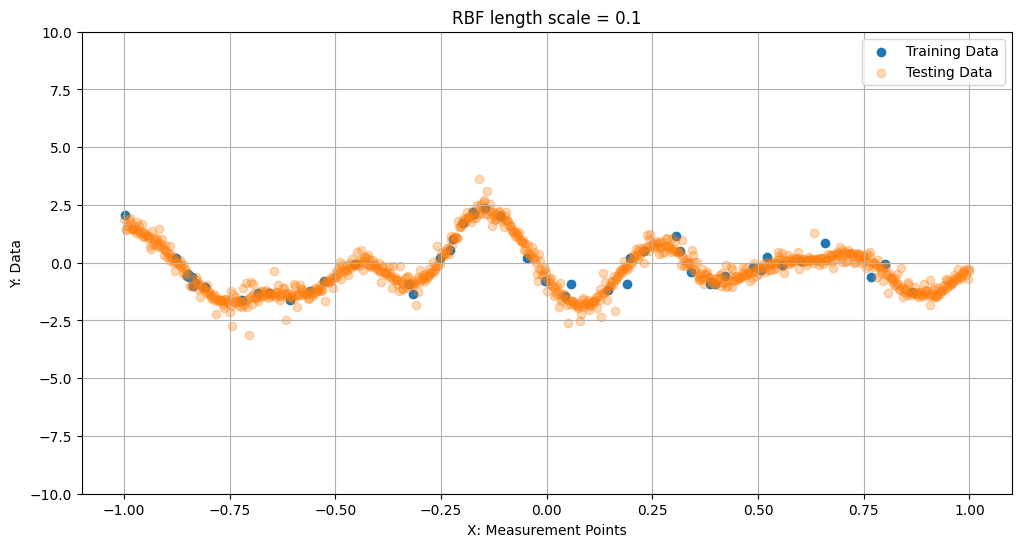

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"RBF length scale = {theta}")

ax.scatter(Xtrn, Ytrn, label="Training Data")
ax.scatter(Xtst, Ytst, label="Testing Data", alpha=0.30)

ax.set_ylim(-10, 10)
ax.set_xlabel("X: Measurement Points")
ax.set_ylabel("Y: Data")
ax.legend()
ax.grid()
fig.show()

In [ ]:
#gaussian process from scratch


#so first we need to solve linear algebra equations (eqns: 2.25-6)
#that's it! that's the entire model! but it's complicated
#esp inverting a matrix


def fit_GP(Xtrn, Etrn, Ytrn, num_tst, theta):
    K = rbf_kernel(Xtrn, Xtrn, theta)
    W = white_noise_kernel(Etrn)

    L = np.linalg.cholesky(K + W)

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, Ytrn))
    nLML = -((-1/2) * np.dot(Ytrn, alpha) - np.sum(np.log(np.diag(L))) - (num_tst / 2) * np.log(2 * np.pi))

    return K, W, L, alpha, nLML


def predict_GP(Xtrn, Xprd, K, W, L, alpha, nLML):
    Ks = rbf_kernel(Xprd, Xtrn, theta)
    fbar_s = np.dot(Ks.T, alpha)

    Kss = rbf_kernel(Xprd, Xprd, theta)
    v = np.linalg.solve(L, Ks)
    V_s = Kss - np.dot(v.T, v)
    sigma = np.sqrt(np.abs(np.diag(V_s)))

    return Ks, fbar_s, Kss, v, V_s, sigma

In [ ]:
theta_guess = 0.1

# Fit model
Ktrn, Wtrn, L, alpha, nLML = fit_GP(Xtrn, Etrn, Ytrn, num_tst, theta_guess)
print(Ktrn.shape, Wtrn.shape, L.shape, alpha.shape, nLML)

(50, 50) (50, 50) (50, 50) (50,) 857.3489469451432


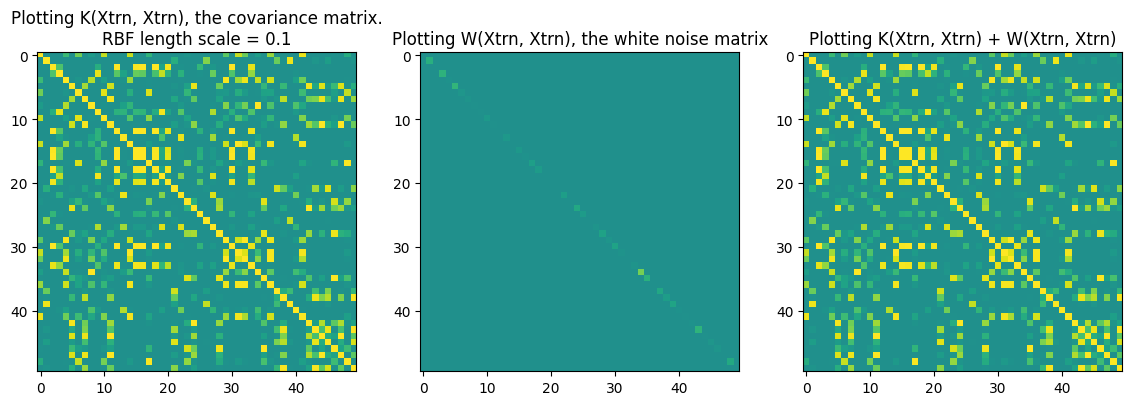

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

ax[0].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[0].imshow(Ktrn,
             vmin=-1, vmax=1
             )

ax[1].set_title("Plotting W(Xtrn, Xtrn), the white noise matrix")
ax[1].imshow(Wtrn,
             vmin=-1, vmax=1
             )

ax[2].set_title("Plotting K(Xtrn, Xtrn) + W(Xtrn, Xtrn)")
ax[2].imshow(Ktrn + Wtrn,
             vmin=-1, vmax=1
             )

fig.show()

In [ ]:
Ks, fbar_s, Kss, v, V_s, sigma = predict_GP(Xtrn, Xtst, Ktrn, Wtrn, L, alpha, nLML)
Ks.shape, fbar_s.shape, Kss.shape, v.shape, V_s.shape, sigma.shape

((50, 950), (950,), (950, 950), (50, 950), (950, 950), (950,))

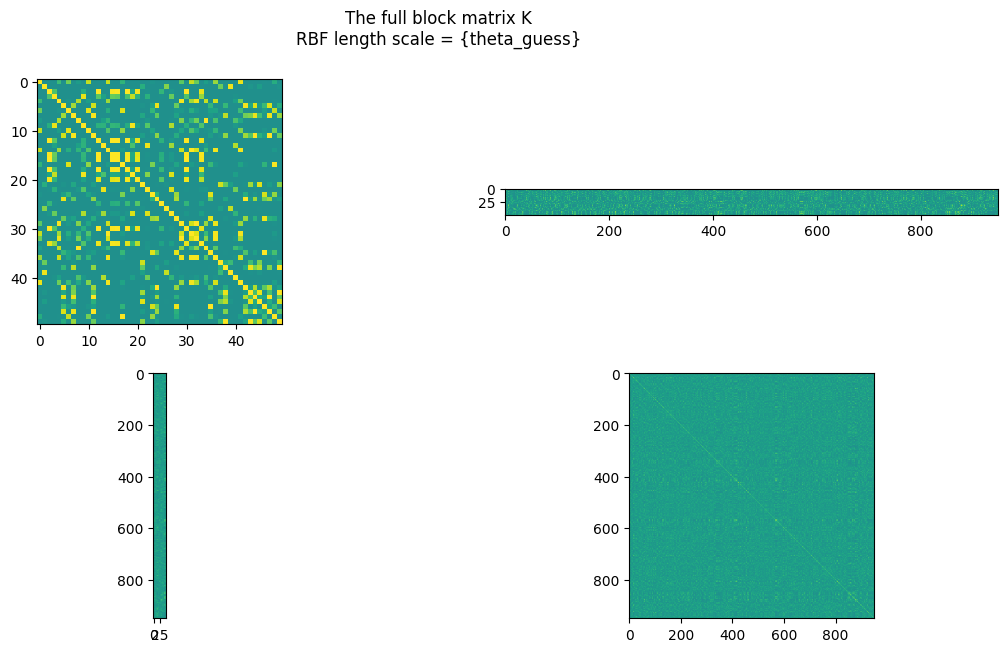

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 7))

# ax[0, 0].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[0, 0].imshow(Ktrn, vmin=-1, vmax=1)

# ax[0, 1].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[0, 1].imshow(Ks, vmin=-1, vmax=1)

# ax[1, 0].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[1, 0].imshow(Ks.T, vmin=-1, vmax=1)

# ax[1, 1].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[1, 1].imshow(Kss, vmin=-1, vmax=1)

fig.suptitle("The full block matrix K\nRBF length scale = {theta_guess}")

fig.show()

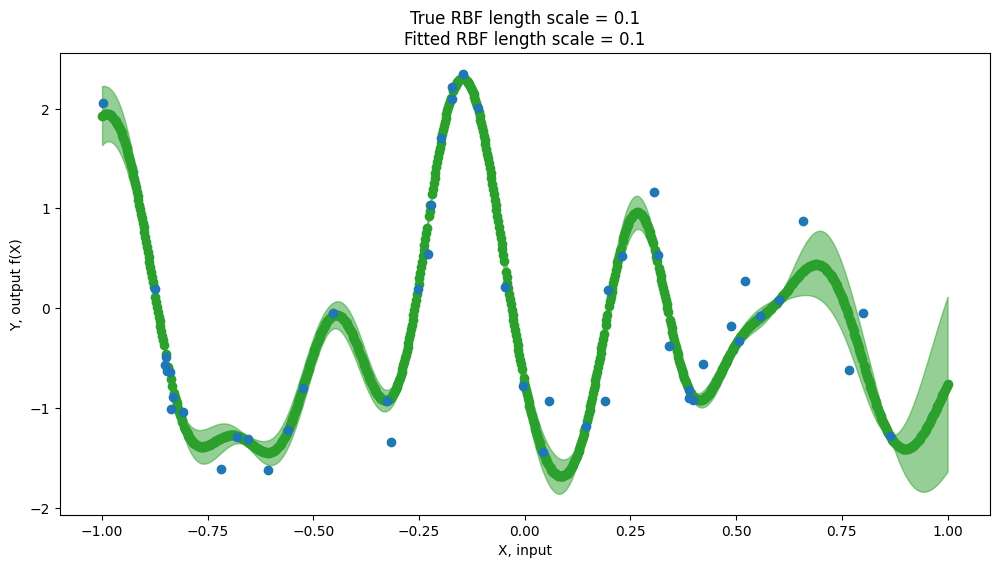

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"True RBF length scale = {theta}\nFitted RBF length scale = {theta_guess}")

# ax.scatter(Xtrn, Ytrn, label="Training Data", c="tab:blue")
# ax.scatter(Xtst, Ytst, label="Testing Data", c="tab:orange")

ax.scatter(Xtst, fbar_s, label="Testing Data", c="tab:green")
ind = np.argsort(Xtst)
ax.fill_between(Xtst[ind], fbar_s[ind] - sigma[ind], fbar_s[ind] + sigma[ind],
                alpha=0.5, color="tab:green")

ax.scatter(Xtrn, Ytrn, label="Training Data", c="tab:blue")

# ax.errorbar(
#     Xtst, fbar_s, label="Prediction", c="tab:green",
#     yerr=sigma,
#     ls="", marker="o", ms=5,
#     elinewidth=1, capsize=5,
#     )





# ax.set_ylim(-10, 10)
ax.set_xlabel("X, input")
ax.set_ylabel("Y, output f(X)")
fig.show()

in green: predicted. in blue = train. the shaded green shows the errors


can be "too confident"
we can try to reduce the white noise.
~will look good


so Gaussian is good for "gapped" data.

Gaussian: if we know the underlying covariance, Gaussian process is good at filling those gaps.

~do i know what the underlying covariance of my data is? probably not.

~can i use one of these kernels to approximate it?

determined by the kernel

--can change theta_guess,
experiment around the parameters.

so, we GUESS the right model, and train it.

*overfitting ~extremely good at sample, but wouldn't be so good if applied in other samples.

# Optimizing the Gaussian process regressor

In [ ]:
#outline:
#we want to try to fit this model. pretend we don't know theta_guess
#use optimizer method.
#use nLML to determine if it's a good model
#minimize it


# def objective_function(parameter, data):

  #going to return nLML

def objective_function(theta, Xtrn, Etrn, Ytrn, num_tst):
    K = rbf_kernel(Xtrn, Xtrn, theta)
    W = white_noise_kernel(Etrn)

    L = np.linalg.cholesky(K + W)

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, Ytrn))
    nLML = -((-1/2) * np.dot(Ytrn, alpha) - np.sum(np.log(np.diag(L))) - (num_tst / 2) * np.log(2 * np.pi))


    #searched scipy to determine an optimize function
    #use sc.optimize.minimize

    return nLML

In [ ]:
from scipy.optimize import minimize

In [ ]:
x0 = 2 #initial guess
res = minimize(objective_function, x0, args=(Xtrn, Etrn, Ytrn, num_tst))

In [ ]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 856.1412858244591
        x: [-8.625e-02]
      nit: 6
      jac: [ 7.629e-06]
 hess_inv: [[ 8.980e-05]]
     nfev: 20
     njev: 10